
**GROUP MEMBERS:**

| Name                 | Roll No          |
|----------------------|------------------|
| Kocherla Sai Kiran   | ai24mtech02003   |
| Kota Dhana Lakshmi   | ai22btech11012   |
| Sanskriti Agarwal    | cs24mtech14002   |


# TrustRank Implementation with Pregel Architecture

## **Dataset Description: Payment Transactions and Fraudulent Senders**

This dataset consists of two files:

### **1. Payments.xlsx**
This file contains financial transaction records between senders and receivers.

#### **Columns:**
- **Sender**: The ID of the sender making the payment.
- **Receiver**: The ID of the receiver receiving the payment.
- **Amount**: The transaction amount in an unspecified currency.

#### **Sample Data:**
<table>
  <tr>
    <th>Sender</th>
    <th>Receiver</th>
    <th>Amount</th>
  </tr>
  <tr>
    <td>1309</td>
    <td>1011</td>
    <td>123051</td>
  </tr>
  <tr>
    <td>1309</td>
    <td>1011</td>
    <td>118406</td>
  </tr>
  <tr>
    <td>1309</td>
    <td>1011</td>
    <td>112456</td>
  </tr>
  <tr>
    <td>1309</td>
    <td>1011</td>
    <td>120593</td>
  </tr>
  <tr>
    <td>1309</td>
    <td>1011</td>
    <td>166396</td>
  </tr>
</table>

---

### **2. bad_sender.xlsx**
This file contains a list of fraudulent senders flagged for suspicious activity.

#### **Columns:**
- **Bad Sender**: The ID of senders that have been flagged as fraudulent.

#### **Sample Data:**
<table>
  <tr>
    <th>Bad Sender</th>
  </tr>
  <tr>
    <td>1303</td>
  </tr>
  <tr>
    <td>1259</td>
  </tr>
  <tr>
    <td>1562</td>
  </tr>
  <tr>
    <td>1147</td>
  </tr>
  <tr>
    <td>1393</td>
  </tr>
</table>

---

### **Usage**
These datasets can be used to compute **Trust Rank** using the Pregel Framework, where:
- Payment transactions define the graph structure (edges).
- Fraudulent senders provide a known set of low-trust nodes.

### **Processing Steps**
1. Load the transaction dataset and fraudulent sender list.
2. Construct a directed graph where:
   - Nodes represent unique sender and receiver IDs.
   - Edges represent transactions with `Amount` as edge weight.
3. Apply **TrustRank**:
   - Assign initial low trust values to bad senders.
   - Propagate trust through the graph using an iterative algorithm.

This dataset is crucial for **fraud detection** and **network analysis** in financial transactions.


## Implementation Overview
This implementation uses a vertex-centric Pregel model to compute TrustRank scores in a distributed fashion. Key components:

1. **Vertex Class**: Represents accounts with trust propagation logic
2. **Worker Class**: Thread-based parallel processing unit
3. **Pregel Engine**: Orchestrates superstep iterations and message passing
4. **Trust Propagation**: Combines personalized PageRank with fraud indicators

Key mathematical components:
- Trust score update: `t(p) = (1-α)d(p) + αΣ(t(q)/w(q))`
- Damping factor (α) = 0.85
- Parallel message passing between vertices
- Mass redistribution for dangling nodes

# Trust Score Update Formula Explanation

Given the trust score update formula:

$$
t(p) = (1 - \text{damping}) \cdot d(p) + \text{damping} \cdot \sum \frac{t(q)}{w(q)}
$$

**Explanation of Terms**:

- **$t(p)$**  
  The updated trust score for the vertex $p$.

- **$(1 - \text{damping})$**  
  A weight that determines how much of the new score comes from the vertex’s own intrinsic bias.  


- **$d(p)$**  
  The bias (or direct trust) associated with vertex $p$.  
  In TrustRank, this is typically nonzero only for seed (trusted) vertices.

- **damping**  
  The parameter (often denoted by $\alpha$ in literature) that balances between the intrinsic bias $d(p)$ and the trust coming from neighboring vertices.

- **$\displaystyle \sum \frac{t(q)}{w(q)}$**  
  This sum aggregates the contributions from each in-neighbor $q$ of $p$.  
  - **$t(q)$**: The trust score of an in-neighbor $q$.  
  - **$w(q)$**: The normalization term, which is the sum of the weights of all edges leaving $q$.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import threading


## Vertex Class Implementation

### Vertex Functionality
- Stores account relationships and trust values
- Manages incoming/outgoing messages
- Implements TrustRank update rule
- Handles edge weights and message propagation

Key attributes:
- `out_edges`: Normalized transaction weights
- `value`: Current trust score
- `bias`: Seed bias (1/|S| for fraud seeds)
- `active`: Convergence status flag
- `incoming_messages`: Aggregated trust from neighbors

In [2]:
# -------------------------------
# Vertex Class for TrustRank
# -------------------------------
class Vertex:
    def __init__(self, vertex_id):
        """
        Initializes a vertex representing an account.
        Attributes:
            id: Unique account identifier.
            out_edges: List of tuples (neighbor_id, weight).
            value: Current TrustRank score t*(p).
            bias: Seed bias d(p); for known fraudulent accounts, d(p)=1/|seeds|; for others, d(p)=0.
            incoming_messages: List of contributions received from in-neighbors.
            outgoing_messages: List of messages to send in the current superstep.
            active: Flag indicating if further updates are required.
            superstep: Current iteration number.
        """
        self.id = vertex_id
        self.out_edges = []
        self.value = 0.0
        self.bias = 0.0
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

    def add_edge(self, neighbor, weight):
        """Adds a directed edge from this vertex to a neighbor with the specified weight."""
        self.out_edges.append((neighbor, weight))

    def update(self, damping, threshold, total_vertices):
        """
        Updates the vertex's TrustRank score.
        Formula:
            new_value = (1-damping) * (bias) + damping * (sum of incoming messages)
        """
        total_incoming = sum(self.incoming_messages) if self.incoming_messages else 0.0

        new_value = (1 - damping) * (self.bias ) + damping * total_incoming
        change = abs(new_value - self.value)
        self.value = new_value
        if change < threshold:
            self.active = False

        # Prepare outgoing messages.
        self.outgoing_messages = []
        if self.out_edges:
            total_weight = sum(weight for (_, weight) in self.out_edges)
            for (neighbor, weight) in self.out_edges:
                # Each outgoing message carries the proportion of the vertex's value.
                msg = self.value * (weight / total_weight)
                self.outgoing_messages.append((neighbor, msg))


## Worker Class in a Pregel-like Framework

**Purpose:**  
The `Worker` class extends `threading.Thread` to enable parallel updates of a subset of vertices.

**Key Elements:**

- **vertices:**  
  A list of vertices (graph nodes). Each vertex has:
  - An `active` flag to indicate if it should be updated.
  - An `update` method for computation.

- **Parameters:**
  - **damping:** A factor (like in PageRank) that scales neighbor influence.
  - **threshold:** A cutoff value to decide if an update is significant.
  - **total_vertices:** The overall number of vertices, used for normalization.

**Behavior:**  
In the `run` method, the Worker iterates over its vertices, and for each active vertex, it calls:
  
```python
vertex.update(self.damping, self.threshold, self.total_vertices)


In [3]:
# -------------------------------
# Worker Class for Parallel Processing
# -------------------------------
class Worker(threading.Thread):
    def __init__(self, vertices, damping, threshold, total_vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices
        self.damping = damping
        self.threshold = threshold
        self.total_vertices = total_vertices

    def run(self):
        for vertex in self.vertices:
            if vertex.active:
                vertex.update(self.damping, self.threshold, self.total_vertices)



## Pregel Engine for TrustRank Computation: Analytical Overview

The `PregelEngine` class implements a Pregel-like iterative algorithm for TrustRank, updating vertices in parallel across supersteps until convergence or a maximum number of iterations is reached.

### Key Components

- **Vertices:**  
  A dictionary mapping account IDs to vertex objects, each with:
  - **Active status**: Determines participation in supersteps
  - **TrustRank value**: Core computation metric
  - **Message buffers**:
    - `incoming_messages`: Accumulates inputs from the previous superstep
    - `outgoing_messages`: Queues outputs for the next superstep

- **Parameters:**
  - **num_workers:** Number of parallel worker threads
  - **Damping ($\alpha$):** Balances the vertex’s **seed bias** against the influence of **neighbor contributions**:
    
    $$
    \text{new\_rank} = (1 - \alpha) \cdot \text{bias} + \alpha \sum \text{incoming_messages}
    $$

    where:
    - $\text{bias} = \frac{1}{|L|}$ if the vertex is a known bad sender (in the seed set), and $0$ otherwise.
    - $\sum \text{incoming_messages}$ is the total trust score passed from in-neighbors during the previous superstep.
    - $\alpha$ is typically set to 0.85.

  - **Threshold ($\epsilon$):** Minimum change required to keep a vertex active.
  - **max_supersteps:** Maximum iterations allowed.

### Core Methods

- **partition_vertices():**  
  Distributes vertices among workers via consistent hashing:
  
  $$
  \text{worker_id} = \text{hash}(\text{vertex.id}) \mod \text{num_workers}
  $$

- **run():**  
  Main control loop:
  1. **Parallel Update:**  
     Worker threads process vertex partitions simultaneously:
     - Each vertex combines **its seed bias** $(1-\alpha) \cdot \text{bias}$ with weighted neighbor contributions.
     - Compares change to the previous value using the $\epsilon$ threshold.
     - Deactivates if changes are below threshold.
  2. **Message Handling:**  
     - Clears previous incoming messages.
     - Routes outgoing messages to target vertices.
     - **Dangling nodes (vertices with no out-edges) do not produce outgoing messages.** Their accumulated mass is **redistributed in post-processing.**
     - Reactivates vertices receiving new messages.
  3. **Superstep Control:**  
     Increments counter until convergence or max supersteps.

- **_any_active():**  
  Global activation check:
  
  $$
  \text{any_active}() = \sum_{v \in \text{vertices}} v.\text{active} > 0
  $$

### Relation to Pregel

- **Vertex-Centric Model:**  
  Mirroring Pregel's `compute()`, vertices update using:
  ```python
  vertex.update(damping, threshold, total_vertices)


In [4]:
#-------------------------------
# Pregel Engine for TrustRank Computation
# -------------------------------
class PregelEngine:
    def __init__(self, vertices, num_workers, damping, threshold, max_supersteps):
        """
        Initializes the Pregel engine.
        Parameters:
            vertices: Dictionary mapping account IDs to Vertex objects.
            num_workers: Number of worker threads.
            damping: Damping factor α in the TrustRank update.
            threshold: Convergence threshold for per-vertex updates.
            max_supersteps: Maximum number of iterations.
        """
        self.vertices = vertices
        self.num_workers = num_workers
        self.damping = damping
        self.threshold = threshold
        self.max_supersteps = max_supersteps

    def partition_vertices(self):
        """
        Partitions vertices among workers using a simple hash.
        Returns a dictionary mapping worker ID to a list of vertices.
        """
        partition = collections.defaultdict(list)
        for vertex in self.vertices.values():
            worker_id = hash(vertex.id) % self.num_workers
            partition[worker_id].append(vertex)
        return partition

    def run(self):
        """
        Executes the Pregel computation until all vertices are inactive or the maximum number of iterations is reached.
        """
        total_vertices = len(self.vertices)
        partition = self.partition_vertices()
        superstep = 0
        while self._any_active() and superstep < self.max_supersteps:
            # Launch worker threads to update vertices in parallel.
            workers = []
            for vertex_list in partition.values():
                worker = Worker(vertex_list, self.damping, self.threshold, total_vertices)
                workers.append(worker)
                worker.start()
            for worker in workers:
                worker.join()

            # Prepare for the next superstep: clear incoming messages.
            for vertex in self.vertices.values():
                vertex.superstep += 1
                vertex.incoming_messages = []  # Clear messages from the previous round.

            # Distribute outgoing messages.
            for vertex in self.vertices.values():
                for (neighbor, msg) in vertex.outgoing_messages:
                    if neighbor in self.vertices:
                        self.vertices[neighbor].incoming_messages.append(msg)



            # Reactivate vertices that received new messages.
            for vertex in self.vertices.values():
                if vertex.incoming_messages and not vertex.active:
                    vertex.active = True

            superstep += 1
            print(f"Superstep {superstep} completed.")
        print("Pregel computation completed.")

    def _any_active(self):
        """Returns True if any vertex is still active."""
        return any(vertex.active for vertex in self.vertices.values())


## Data Loading Functions: Analytical Overview

### **load_payments(file_path)**

- **Purpose:**  
  Constructs a graph from payment data stored in an Excel file.

- **Expected Columns:**  
  - **Sender:** Identifier for the source account.  
  - **Receiver:** Identifier for the destination account.  
  - **Amount:** Numeric value representing the weight of the payment (edge weight).  

- **Process:**  
  1. Read the Excel file into a DataFrame.
  2. For each row:
     - Extract and clean the sender and receiver IDs.
     - Convert the "Amount" to a float. **Rows with invalid amounts are skipped.**
  3. Build a graph as a dictionary where:
     
     ```python
     graph = { "account_id": Vertex(account_id) }
     ```
     
  4. If a sender or receiver **does not already exist** in the graph, **create a new `Vertex` object** for them.
  5. For valid rows, **add an edge** from the sender to the receiver with the given weight.

---

### **load_fraudulent(file_path)**

- **Purpose:**  
  Loads a set of fraudulent account IDs from an Excel file.

- **Expected Column:**  
  - **Bad Sender:** Identifier for accounts flagged as fraudulent.

- **Process:**  
  1. Read the Excel file into a DataFrame.
  2. Iterate over the rows to extract and clean each fraudulent account ID **using `.strip()` to remove extra spaces.**
  3. Insert each cleaned ID into a `set` to ensure uniqueness:
     
     ```python
     fraudulent = { "account_id_1", "account_id_2", ... }
     ```


In [5]:
# -------------------------------
# Data Loading Functions
# -------------------------------
def load_payments(file_path):
    """
    Loads payment data from an Excel file.
    Expected columns: 'Sender', 'Receiver', 'Amount'.
    Returns a dictionary mapping account IDs to Vertex objects.
    """
    df = pd.read_excel(file_path)
    graph = {}
    for _, row in df.iterrows():
        sender = str(row["Sender"]).strip()
        receiver = str(row["Receiver"]).strip()
        try:
            weight = float(row["Amount"])
        except (ValueError, TypeError):
            continue

        if sender not in graph:
            graph[sender] = Vertex(sender)
        if receiver not in graph:
            graph[receiver] = Vertex(receiver)
        graph[sender].add_edge(receiver, weight)
    return graph

def load_fraudulent(file_path):
    """
    Loads fraudulent account IDs from an Excel file.
    Expected column: 'Bad Sender'.
    Returns a set of fraudulent account IDs.
    """
    df = pd.read_excel(file_path)
    fraudulent = set()
    for _, row in df.iterrows():
        sender = str(row["Bad Sender"]).strip()
        fraudulent.add(sender)
    return fraudulent


## Main Execution: TrustRank Computation and Redistribution

This section outlines the overall workflow for computing and adjusting TrustRank scores using a Pregel-based engine.

### Data Loading and Vertex Initialization

1. **Load Data:**
   - **Payments:**  
     Reads an Excel file (columns: `Sender`, `Receiver`, `Amount`) to build a graph:
     
     $$
     \text{graph} = \{ \text{account\_id} : \text{Vertex} \}
     $$
     
   - **Fraudulent Accounts:**  
     Loads a set of bad senders from an Excel file (column: `Bad Sender`).

2. **Initialize Vertices:**
   - For each vertex, assign:
     - **If fraudulent:**  
       $$
       \text{init\_val} = \frac{1}{\text{num\_bad\_senders}}
       $$
       Both `value` and `bias` are set to `init_val`.
     - **Otherwise:**  
       Both `value` and `bias` are set to 0.

### TrustRank Propagation via PregelEngine

- **Parameters:**
  - **Damping Factor ($\alpha$)**: 0.85  
  - **Threshold ($\epsilon$)**: 0.001  
  - **Maximum Supersteps:** 100  
  - **Number of Workers:** 4

- **Execution:**  
  The PregelEngine runs iterative supersteps. In each superstep:
  - Worker threads update active vertices via:
    
    $$
    \text{vertex.update}(\alpha, \epsilon, N)
    $$
    
    where $N$ is the total number of vertices.
  - Messages are exchanged, vertices are reactivated if they receive new messages, and the superstep counter increments.

### Post-Processing and Trust Redistribution

1. **Total Trust Score Calculation:**
   
   $$
   \text{Total Trust} = \sum_{\text{vertex} \in \text{graph}} \text{vertex.value}
   $$

2. **Redistribution:**
   - Compute remaining mass:
     
     $$
     \text{remaining mass} = 1.0 - \text{Total Trust}
     $$
     
   - Distribute equally among fraudulent accounts:
     
     $$
     \text{additional trust} = \frac{\text{remaining mass}}{\text{num\_bad\_senders}}
     $$

### Output and Categorization

- **Export:**  
  The adjusted trust scores are saved to an Excel file.
  
- **Re-categorization:**
  - Calculate the 90th percentile of trust scores as the outlier threshold.
  - Classify each account as:
    - **Known Fraud Sender:** if in the fraudulent set.
    - **Genuine Sender:** if trust score < threshold.
    - **Discovered Fraud Sender:** otherwise.
  
- **Display:**  
  Top 30 accounts by trust score are printed.

This workflow integrates data preparation, parallel TrustRank computation, and post-processing redistribution and categorization to flag potential fraudulent accounts.


In [6]:

if __name__ == "__main__":
    # Define input file paths.
    payments_file = '/content/Payments.xlsx'
    fraudulent_file = '/content/bad_sender.xlsx'
    # Load payment data and fraudulent account list.
    graph = load_payments(payments_file)
    fraudulent_set = load_fraudulent(fraudulent_file)
    # Compute the number of bad senders.
    num_bad_senders = len(fraudulent_set)
    # Initialize vertices:
    # - Known fraudulent accounts: d(p) = 1/num_bad_senders (and initial trust = 1/num_bad_senders)
    # - All other accounts: d(p) = 0 (and initial trust = 0)
    for vertex_id, vertex in graph.items():
        if vertex_id in fraudulent_set:
            init_val = 1.0 / num_bad_senders if num_bad_senders > 0 else 0.0
            vertex.value = init_val
            vertex.bias = init_val
        else:
            vertex.value = 0.0
            vertex.bias = 0.0
    # Set Pregel/TrustRank parameters.
    damping = 0.85          # Damping factor (trust propagation weight)
    threshold = 0.001       # Convergence threshold for per-vertex updates
    max_supersteps = 100    # Maximum iterations allowed
    num_workers = 4         # Number of parallel worker threads

    # Print algorithm parameters
    print("\n" + "="*50)
    print(f"{'TRUSTRANK ALGORITHM PARAMETERS':^50}")
    print("="*50)
    params_table = [
        ["Damping Factor", f"{damping:.2f}"],
        ["Convergence Threshold", f"{threshold:.6f}"],
        ["Max Iterations", f"{max_supersteps}"],
        ["Worker Threads", f"{num_workers}"]
    ]
    for param, value in params_table:
        print(f"| {param:<30} | {value:>15} |")
    print("-"*50)

    # Run the Pregel-based TrustRank propagation.
    print("\nExecuting TrustRank propagation...")
    engine = PregelEngine(graph, num_workers, damping, threshold, max_supersteps)
    engine.run()


    # Compute the total trust score.
    total_trust_score = sum(vertex.value for vertex in graph.values())
    # Compute the remaining trust mass to be redistributed.
    remaining_mass = 1.0 - total_trust_score

    # Display trust mass statistics
    print("\n" + "="*50)
    print(f"{'TRUST MASS DISTRIBUTION':^50}")
    print("="*50)
    print(f"| {'Trust Score Before Redistribution':<35} | {total_trust_score:.10f} |")
    print(f"| {'Remaining Mass':<35} | {remaining_mass:.10f} |")

    # Redistribute the remaining mass among the known fraudulent senders.
    if num_bad_senders > 0:
        additional_trust_per_fraud = remaining_mass / num_bad_senders
        for vertex_id in fraudulent_set:
            if vertex_id in graph:
                graph[vertex_id].value += additional_trust_per_fraud

    # Compute the total trust score after redistribution
    total_trust_score_after = sum(vertex.value for vertex in graph.values())
    print(f"| {'Trust Score After Redistribution':<35} | {total_trust_score_after:.10f} |")
    print("-"*50)

    # Save the updated trust scores to an Excel file.
    output_data = [{'AccountID': vertex.id, 'TrustScore': vertex.value} for vertex in graph.values()]
    df_output = pd.DataFrame(output_data)

    # Save the adjusted trust scores.
    output_excel_path = '/content/CompleteTrustScores_Adjusted.xlsx'
    df_output.to_excel(output_excel_path, index=False)
    print(f"\nAdjusted trust scores saved to: {output_excel_path}")

    # Recalculate the outlier threshold based on the new trust scores.
    outlier_threshold = df_output['TrustScore'].quantile(0.90)
    print(f"Outlier threshold (90th percentile): {outlier_threshold:.10f}")

    # Re-categorize accounts.
    def categorize(row):
        if row['AccountID'] in fraudulent_set:
            return 'Known Fraud Sender'
        elif row['TrustScore'] < outlier_threshold:
            return 'Genuine Sender'
        else:
            return 'Discovered Fraud Sender'

    df_output['Category'] = df_output.apply(categorize, axis=1)



    # Display the updated top accounts by trust score.
    top_accounts = df_output.sort_values(by='TrustScore', ascending=False).head(30)

    print("\n" + "="*75)
    print(f"{'TOP 30 ACCOUNTS BY TRUST SCORE (ADJUSTED)':^75}")
    print("="*75)
    print(f"| {'Rank':<4} | {'AccountID':<30} | {'TrustScore':<15} ")
    print("-"*75)

    for i, (_, row) in enumerate(top_accounts.iterrows(), 1):
        print(f"| {i:<4} | {row['AccountID']:<30} | {row['TrustScore']:<15.10f} |")

    print("-"*75)
    # Re-categorize accounts.(optional)
    def categorize(row):
        if row['AccountID'] in fraudulent_set:
            return 'Known Fraud Sender'
        elif row['TrustScore'] < outlier_threshold:
            return 'Genuine Sender'
        else:
            return 'Discovered Fraud Sender'






          TRUSTRANK ALGORITHM PARAMETERS          
| Damping Factor                 |            0.85 |
| Convergence Threshold          |        0.001000 |
| Max Iterations                 |             100 |
| Worker Threads                 |               4 |
--------------------------------------------------

Executing TrustRank propagation...
Superstep 1 completed.
Superstep 2 completed.
Superstep 3 completed.
Superstep 4 completed.
Superstep 5 completed.
Superstep 6 completed.
Superstep 7 completed.
Superstep 8 completed.
Superstep 9 completed.
Superstep 10 completed.
Superstep 11 completed.
Superstep 12 completed.
Superstep 13 completed.
Superstep 14 completed.
Superstep 15 completed.
Superstep 16 completed.
Superstep 17 completed.
Superstep 18 completed.
Superstep 19 completed.
Superstep 20 completed.
Superstep 21 completed.
Superstep 22 completed.
Superstep 23 completed.
Superstep 24 completed.
Superstep 25 completed.
Superstep 26 completed.
Superstep 27 completed.
Superstep 

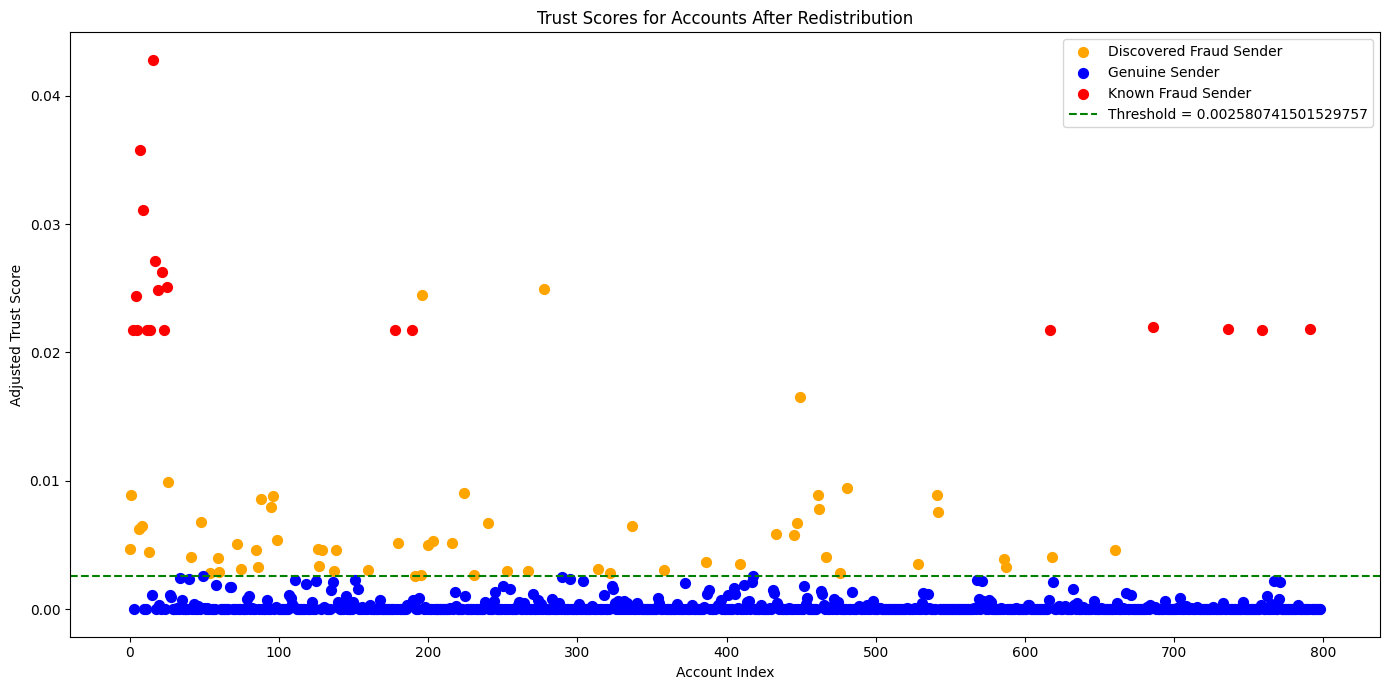

In [7]:

# Plot trust scores after redistribution.
plt.figure(figsize=(14, 7))
colors = {
    'Known Fraud Sender': 'red',
    'Discovered Fraud Sender': 'orange',
    'Genuine Sender': 'blue'
}
for category, group in df_output.groupby('Category'):
    plt.scatter(group.index, group['TrustScore'], color=colors[category],
                label=category, s=50)
plt.axhline(y=outlier_threshold, color='green', linestyle='--',
            label=f'Threshold = {outlier_threshold}')
plt.xlabel('Account Index')
plt.ylabel('Adjusted Trust Score')
plt.title('Trust Scores for Accounts After Redistribution')
plt.legend()
plt.tight_layout()
plt.show()



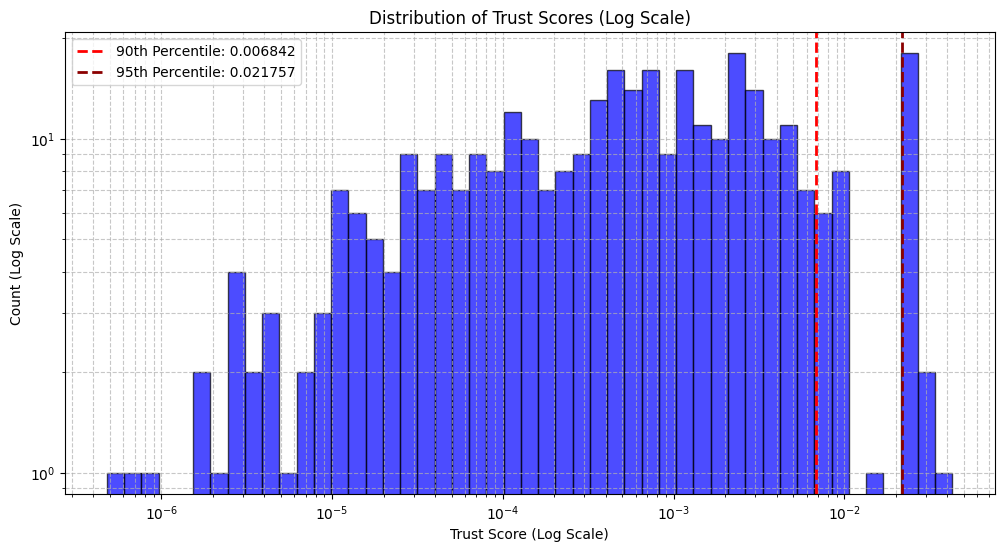

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the adjusted trust scores file
file_path = "CompleteTrustScores_Adjusted.xlsx"  # Update with your actual file path
df_output = pd.read_excel(file_path)

# Remove zero trust scores to avoid log-scale issues
df_output = df_output[df_output['TrustScore'] > 0]

# Define logarithmic bins
bins = np.logspace(np.log10(df_output['TrustScore'].min()), np.log10(df_output['TrustScore'].max()), 50)

# Calculate percentiles for reference lines
percentile_90 = np.percentile(df_output['TrustScore'], 90)
percentile_95 = np.percentile(df_output['TrustScore'], 95)

# Create the histogram with log-log scale
plt.figure(figsize=(12, 6))
plt.hist(df_output['TrustScore'], bins=bins, color='blue', alpha=0.7, edgecolor='black')

# Set both axes to log scale
plt.xscale('log')
plt.yscale('log')

# Add percentile reference lines
plt.axvline(percentile_90, color='red', linestyle='dashed', linewidth=2, label=f'90th Percentile: {percentile_90:.6f}')
plt.axvline(percentile_95, color='darkred', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95:.6f}')

# Labels and title
plt.xlabel('Trust Score (Log Scale)')
plt.ylabel('Count (Log Scale)')
plt.title('Distribution of Trust Scores (Log Scale)')
plt.legend()
plt.grid(which="both", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


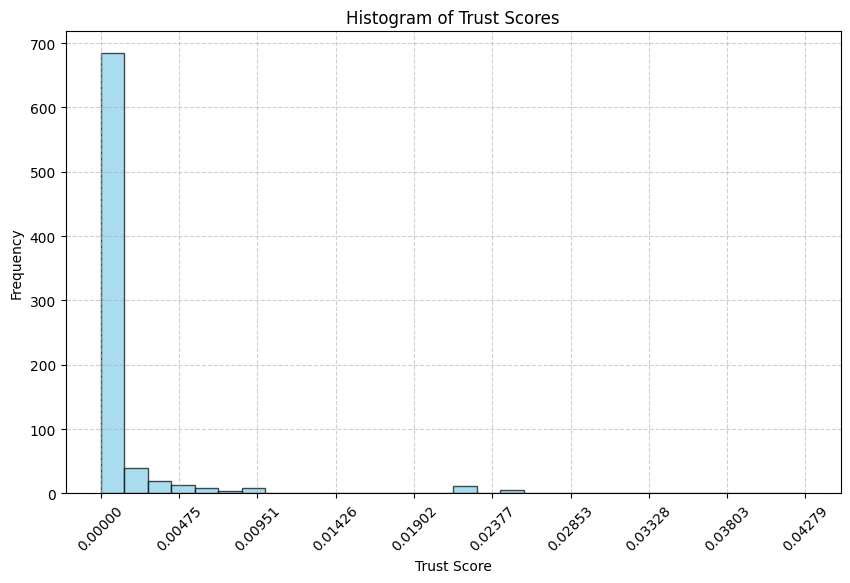

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'graph' is a dictionary where each value has an attribute 'value' representing the trust score
trust_scores = [vertex.value for vertex in graph.values()]

# Convert to NumPy array for efficient computation
trust_scores = np.array(trust_scores)

# Plot histogram with decimal x-axis formatting
plt.figure(figsize=(10, 6))
plt.hist(trust_scores, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Formatting the x-axis
plt.xticks(np.linspace(min(trust_scores), max(trust_scores), num=10))
plt.tick_params(axis='x', rotation=45)  # Rotate x labels for readability

plt.title("Histogram of Trust Scores")
plt.xlabel("Trust Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
